In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, StratifiedKFold
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


In [20]:
df_fin_phrase = pd.read_csv("../../Data/Prepared/CleanDatasets/fin_phrase_bank_clean.csv")


In [21]:
df_fin_phrase.head(1)

,sentence,label,clean_text,sentiment
0,"According to Gran , the company has no plans t...",1,according gran company plan move production ru...,Neutral


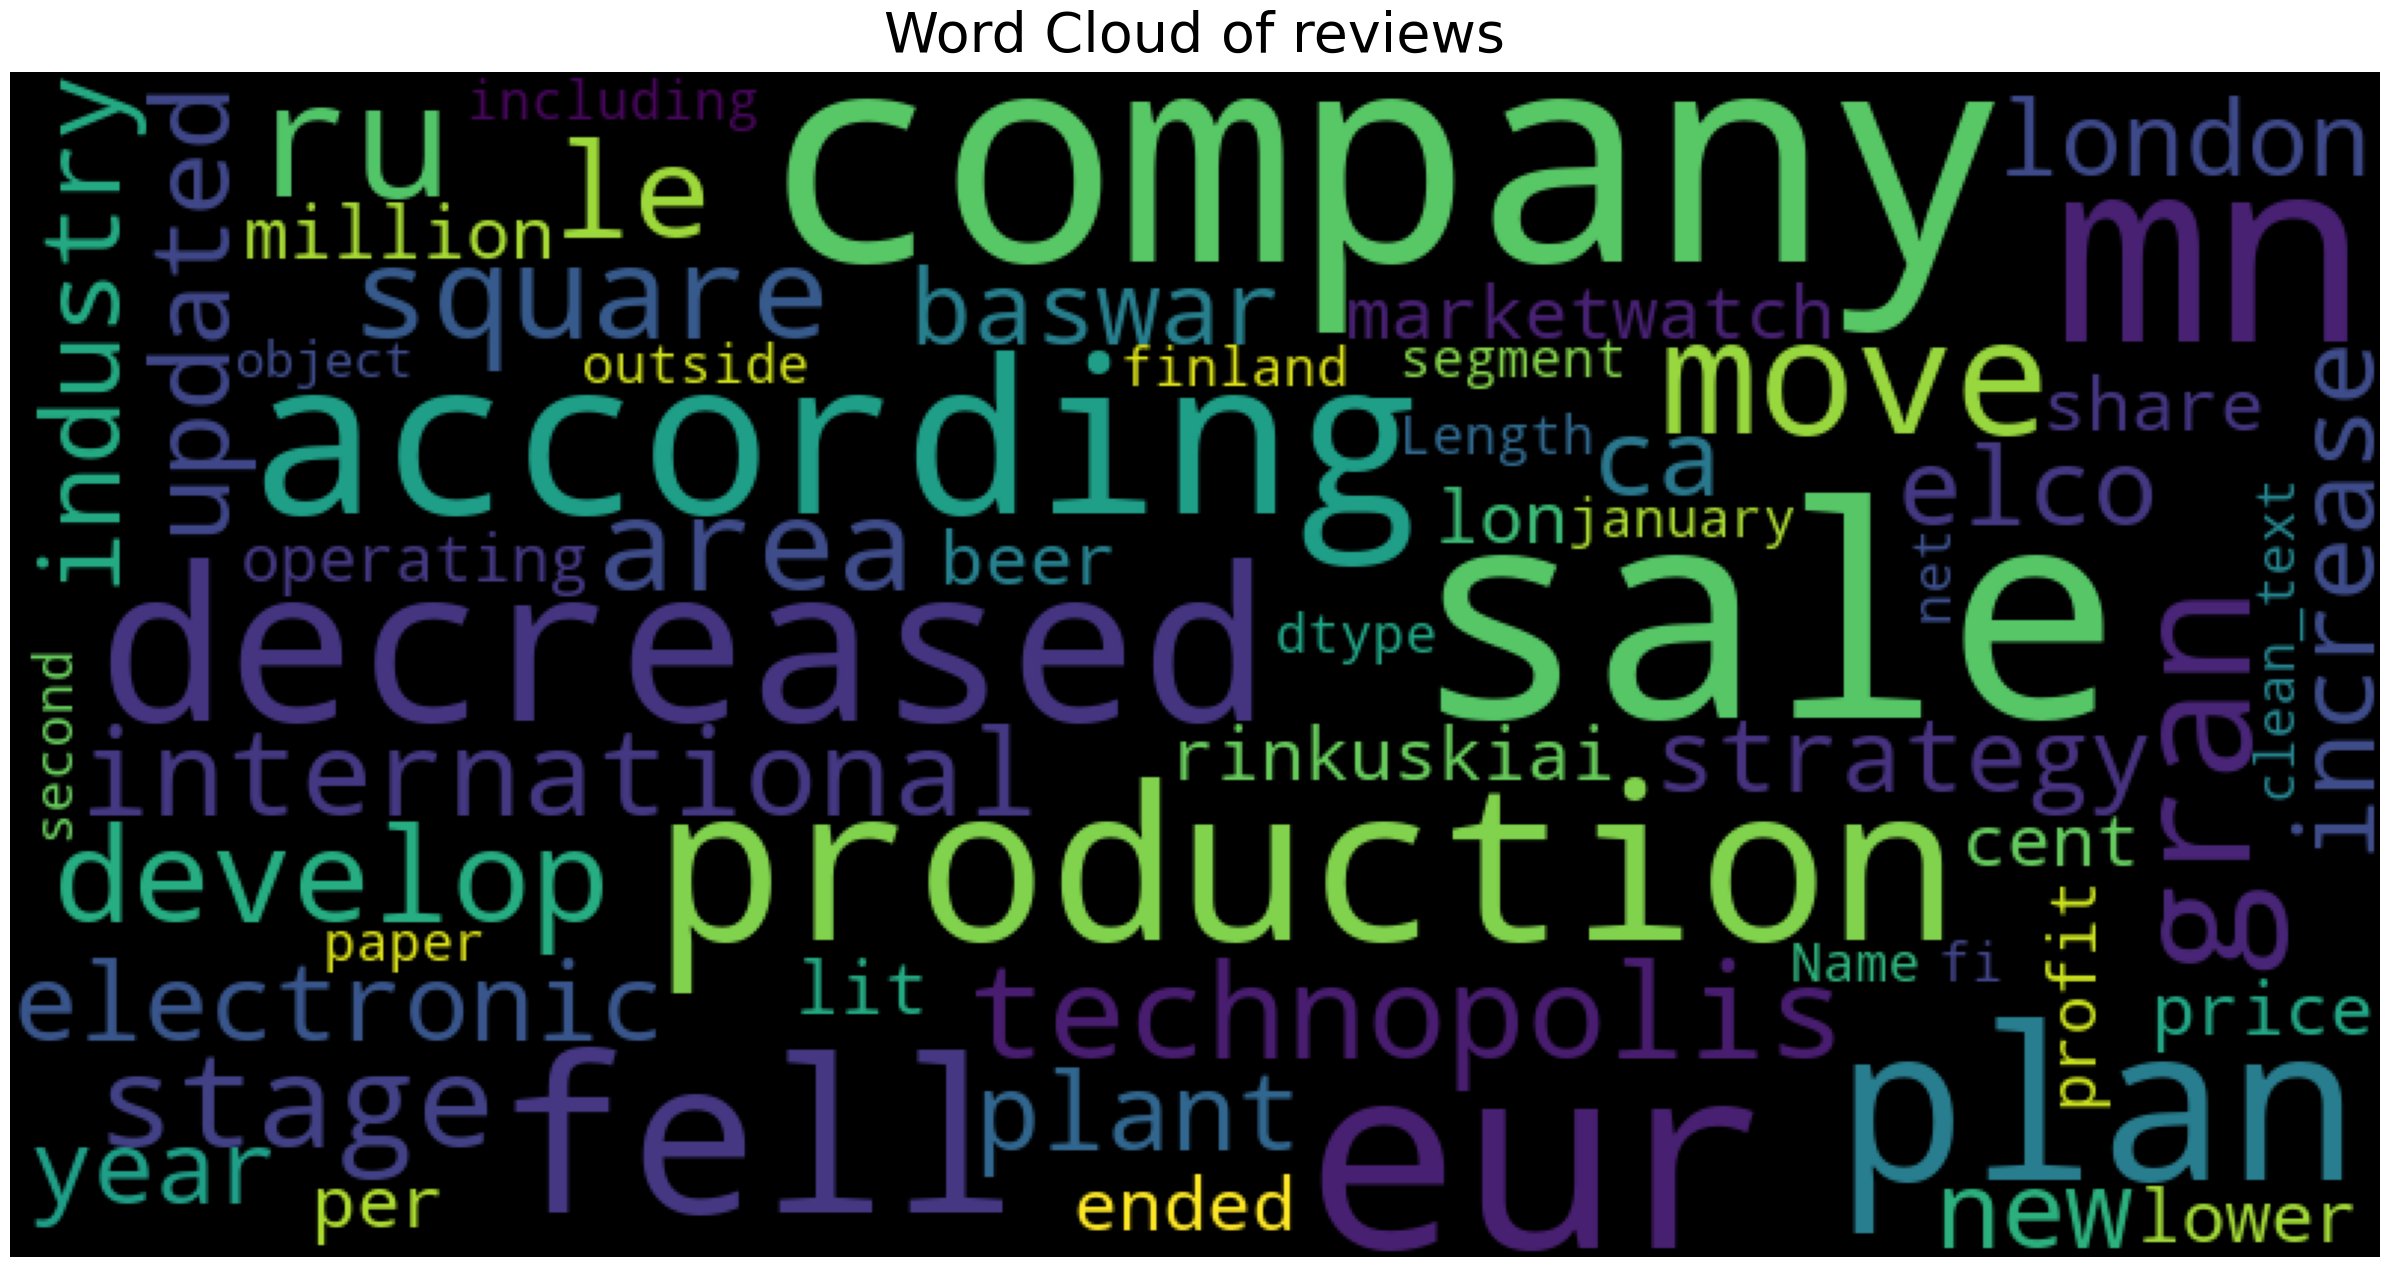

In [22]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(df_fin_phrase["clean_text"], title="Word Cloud of reviews")


In [23]:
df_fin_phrase["clean_text"].fillna(str(0), inplace=True)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df_fin_phrase['clean_text'], df_fin_phrase['label'], test_size=0.3, random_state=42)

In [25]:
text_transformer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), lowercase=True, max_features=150000)

In [26]:
X_test

3207    company supposed deliver machinery veneer mill...
1684    unc charlotte would also deploy ssh tectia con...
1044    lee man combined annual production capacity cl...
4145    high figure european scale noop said recalling...
1538    finland corresponding service alma medium etuo...
                              ...                        
3919                 total investment expected amount eur
3844             expanded company continue called newpage
4150    worm set activate friday corrupt document usin...
2881    equipment manufactured vaahto workshop hollola...
2292    operating profit totaled eur mn compared eur m...
Name: clean_text, Length: 1454, dtype: object

In [27]:
%%time
X_train_text = text_transformer.fit_transform(X_train)
X_test_text = text_transformer.transform(X_test)

CPU times: user 103 ms, sys: 255 µs, total: 104 ms
Wall time: 107 ms


In [28]:
X_train_text.shape, X_test_text.shape

((3392, 32795), (1454, 32795))

In [29]:
logit = LogisticRegression(C=1e3, solver='lbfgs', multi_class='multinomial', random_state=17, n_jobs=4, max_iter=1000)

In [30]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

In [31]:
skf

StratifiedKFold(n_splits=5, random_state=17, shuffle=True)

In [32]:
%%time
cv_results = cross_val_score(logit, X_train_text, y_train , cv=skf, scoring='f1_micro')

CPU times: user 18.7 ms, sys: 59.6 ms, total: 78.3 ms
Wall time: 2.71 s


In [33]:
cv_results, cv_results.mean()

(array([0.74079529, 0.75846834, 0.7300885 , 0.71091445, 0.74631268]),
 0.7373158514386505)

In [34]:
from interpret import show
from interpret.perf import RegressionPerf
from interpret.glassbox import ExplainableBoostingRegressor

# Convert X_train and X_test to numpy arrays or pandas DataFrames
X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)

ebr = ExplainableBoostingRegressor(random_state=1)
ebr.fit(X_train, y_train)

ebr_global = ebr.explain_global()
show(ebr_global)

<!-- http://127.0.0.1:7001/140112649678096/ -->

In [35]:
%%time
logit.fit(X_train_text, y_train)

CPU times: user 11.4 ms, sys: 29.5 ms, total: 40.9 ms
Wall time: 1.15 s


LogisticRegression(C=1000.0, max_iter=1000, multi_class='multinomial', n_jobs=4,
                   random_state=17)

# Testing predictions

In [36]:
test_preds = logit.predict(X_test_text)

In [37]:
pd.DataFrame(test_preds, columns=['label']).head()

,label
0,2
1,1
2,2
3,1
4,1


In [38]:
from sklearn.metrics import accuracy_score, classification_report

In [39]:
accuracy = accuracy_score(y_test, test_preds)
print("Accuracy:", accuracy)

Accuracy: 0.7393397524071527


In [40]:
# Assuming y_test and y_pred are already defined
report = classification_report(y_test, test_preds, output_dict=True)

# Convert the report dictionary to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Optionally, you can reset the index to have the labels as a column
report_df.reset_index(inplace=True)
report_df.rename(columns={'index': 'class'}, inplace=True)

print(report_df)

          class  precision    recall  f1-score     support
0             0   0.687898  0.603352  0.642857   179.00000
1             1   0.785398  0.838253  0.810965   847.00000
2             2   0.653944  0.600467  0.626066   428.00000
3      accuracy   0.739340  0.739340  0.739340     0.73934
4     macro avg   0.709080  0.680691  0.693296  1454.00000
5  weighted avg   0.734700  0.739340  0.735843  1454.00000


In [41]:
len(X_test)

1454

In [42]:
len(y_test)

1454

In [43]:
len(test_preds)

1454

# Here I am assign the label base on the value 

In [44]:
df = pd.DataFrame({'text': X_test.flatten(), 'truelabelNum': y_test, 'prediclabelNum': test_preds.flatten()})
# class 0: negative, class 1: neutral, class 2: positive
df['pred_label'] = df['truelabelNum'].map({0: 'negative', 1: 'neutral', 2: 'positive'})
df['true_label'] = df['prediclabelNum'].map({0: 'negative', 1: 'neutral', 2: 'positive'})

In [45]:
df.to_csv('../../Data/Prepared/TFIDFAnalysis/FinancialLogitReg_tf_idf.csv', index=False)

# Testing the model

In [46]:
sentences = ['growth is strong and we have plenty of liquidity.', 
               'there is a shortage of capital, and we need extra financing.', 
              'formulation patents might protect Vasotec to a limited extent.']

result = []
for sen in sentences:
    sentences_vector = text_transformer.transform([sen]) # vectorizing
    result.append(logit.predict(sentences_vector).prod())


In [47]:
sentences = ['growth is strong and we have plenty of liquidity.', 
               'there is a shortage of capital, and we need extra financing.', 
              'formulation patents might protect Vasotec to a limited extent.']

for sen in sentences:
    sentences_vector = text_transformer.transform([sen]) # vectorizing
    if logit.predict(sentences_vector).prod() == 0:
        print('negative')
    elif logit.predict(sentences_vector).prod() == 1:
        print('neutral')
    else:
        print('positive')



positive
neutral
neutral


# Exporting the model

In [48]:

import pickle
filename = '../../Data/Models/FinancialLogitReg_tf_idf.pt'
pickle.dump(logit, open(filename, 'wb'))

# Testing the twitter data against the model

In [76]:
df_train = pd.read_csv("../../Data/Prepared/CleanDatasets/Tweet_train_clean.csv")
df_test = pd.read_csv("../../Data/Prepared/CleanDatasets/Tweet_valid_clean.csv")


In [77]:
df_train.dropna( inplace=True)
df_test.dropna( inplace=True)

In [78]:
X_train_text = text_transformer.fit_transform(df_train['clean_text'])
X_test_text = text_transformer.transform(df_test['clean_text'])

In [81]:
y_train = df_train['label']
y_test = df_test['label']

In [82]:
X_train_text.shape, X_test_text.shape

((16989, 150000), (4117, 150000))

In [83]:
%%time
cv_results = cross_val_score(logit, X_train_text, y_train , cv=skf, scoring='f1_micro')

CPU times: user 194 ms, sys: 136 ms, total: 331 ms
Wall time: 1min 45s


In [84]:
cv_results, cv_results.mean()

(array([0.8184226 , 0.81106533, 0.824897  , 0.82018835, 0.81483662]),
 0.8178819797893201)

In [85]:
%%time
logit.fit(X_train_text, y_train)

CPU times: user 33.7 ms, sys: 37 ms, total: 70.7 ms
Wall time: 24.3 s


LogisticRegression(C=1000.0, max_iter=1000, multi_class='multinomial', n_jobs=4,
                   random_state=17)

In [86]:
test_preds = logit.predict(X_test_text)

In [87]:
pd.DataFrame(test_preds, columns=['label']).head()

,label
0,0
1,0
2,14
3,2
4,5


In [88]:
from sklearn.metrics import accuracy_score, classification_report

In [89]:
accuracy = accuracy_score(y_test, test_preds)
print("Accuracy:", accuracy)

Accuracy: 0.8311877580762691


In [90]:
# Assuming y_test and y_pred are already defined
report = classification_report(y_test, test_preds, output_dict=True)

# Convert the report dictionary to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Optionally, you can reset the index to have the labels as a column
report_df.reset_index(inplace=True)
report_df.rename(columns={'index': 'class'}, inplace=True)

print(report_df)

           class  precision    recall  f1-score      support
0              0   0.903846  0.643836  0.752000    73.000000
1              1   0.857843  0.817757  0.837321   214.000000
2              2   0.818584  0.868545  0.842825   852.000000
3              3   0.935484  0.753247  0.834532    77.000000
4              4   0.904762  0.979381  0.940594    97.000000
5              5   0.902724  0.958678  0.929860   242.000000
6              6   0.812500  0.801370  0.806897   146.000000
7              7   0.878981  0.862500  0.870662   160.000000
8              8   0.757576  0.781250  0.769231    32.000000
9              9   0.766355  0.732143  0.748858   336.000000
10            10   0.315789  0.461538  0.375000    13.000000
11            11   0.866667  0.928571  0.896552    14.000000
12            12   0.920000  0.773109  0.840183   119.000000
13            13   0.795918  0.672414  0.728972   116.000000
14            14   0.799097  0.853012  0.825175   415.000000
15            15   0.768